In [1]:
%matplotlib inline
import sys

# Directories and paths
lib_path = '/gpfswork/rech/xdy/uze68md/GitHub/'
data_path = '/gpfswork/rech/xdy/uze68md/data/'
model_dir = '/gpfswork/rech/xdy/uze68md/trained_models/model_meerkat/'

# Add library path to PYTHONPATH
path_alphatransform = lib_path+'alpha-transform'
path_score = lib_path+'score'
sys.path.insert(0, path_alphatransform)
sys.path.insert(0, path_score)

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import fft
from galaxy2galaxy import problems
import tensorflow as tf
import galflow as gf
from scipy.ndimage import convolve
import cadmos_lib as cl

tf.enable_eager_execution()

tf.version.VERSION

tf.executing_eagerly()

True

In [2]:
# Functions

def ir2tf_simplifie(imp_resp, shape):
    

    dim = 2
    # Zero padding and fill
    irpadded = np.zeros(shape)
    irpadded[tuple([slice(0, s) for s in imp_resp.shape])] = imp_resp
    # Roll for zero convention of the fft to avoid the phase
    # problem. Work with odd and even size.
    for axis, axis_size in enumerate(imp_resp.shape):

        irpadded = np.roll(irpadded,
                           shift=-int(np.floor(axis_size / 2)),
                           axis=axis)

    return fft.rfftn(irpadded, axes=range(-dim, 0))

def laplacian_simplifie(shape):
    
    impr = np.zeros([3,3])
    for dim in range(2):
        idx = tuple([slice(1, 2)] * dim +
                    [slice(None)] +
                    [slice(1, 2)] * (1 - dim))
        impr[idx] = np.array([-1.0,
                              0.0,
                              -1.0]).reshape([-1 if i == dim else 1
                                              for i in range(2)])
    impr[(slice(1, 2), ) * 2] = 4.0
    return ir2tf_simplifie(impr, shape), impr

def laplacian_tf(shape):
    return tf.convert_to_tensor(laplacian_simplifie(shape)[0])

def wiener_tf(image, psf, balance, laplacian=True):
    r"""Applies Wiener filter to image.

    This function takes an image in the direct space and its corresponding PSF in the
    Fourier space and performs a deconvolution using the Wiener Filter.

    Parameters
    ----------
    image   : 2D TensorFlow tensor
        Image in the direct space.
    psf     : 2D TensorFlow tensor
        PSF in the Fourier space (or K space).
    balance : scalar
        Weight applied to regularization.
    laplacian : boolean
        If true the Laplacian regularization is used else the identity regularization 
        is used.

    Returns
    -------
    tuple
        The first element is the filtered image in the Fourier space.
        The second element is the PSF in the Fourier space (also know as the Transfer
        Function).
    """
    trans_func = psf
    if laplacian:
        reg = laplacian_tf(image.shape)
        if psf.shape != reg.shape:
            trans_func = tf.signal.rfft2d(tf.signal.ifftshift(tf.cast(psf, 'float32')))
        else:
            trans_func = psf
    
    arg1 = tf.cast(tf.math.conj(trans_func), 'complex64')
    arg2 = tf.dtypes.cast(tf.math.abs(trans_func),'complex64') ** 2
    arg3 = balance
    if laplacian:
        arg3 *= tf.dtypes.cast(tf.math.abs(laplacian_tf(image.shape)), 'complex64')**2
    wiener_filter = arg1 / (arg2 + arg3)
    
    # Apply wiener in Foutier (or K) space
    wiener_applied = wiener_filter * tf.signal.rfft2d(tf.cast(image, 'float32'))
    
    return wiener_applied, trans_func

def pre_proc_unet(dico):
    r"""Preprocess the data and apply the Tikhonov filter on the input galaxy images.

    This function takes the dictionnary of galaxy images and PSF for the input and
    the target and returns a list containing 2 arrays: an array of galaxy images that
    are the output of the Tikhonov filter and an array of target galaxy images.

    Parameters
    ----------
    dico : dictionnary
        Array_like means all those objects -- lists, nested lists, etc. --
        that can be converted to an array.  We can also refer to
        variables like `var1`.

    Returns
    -------
    list
        list containing 2 arrays: an array of galaxy images that are the output of the
        Tikhonov filter and an array of target galaxy images.

    Example
    -------
    These are written in doctest format, and should illustrate how to
    use the function.

    >>> from galaxy2galaxy import problems # to list avaible problems run problems.available()
    >>> problem128 = problems.problem('attrs2img_cosmos_hst2euclide')
    >>> dset = problem128.dataset(Modes.TRAIN, data_dir='attrs2img_cosmos_hst2euclide')
    >>> dset = dset.map(pre_proc_unet)
    """
    # First, we interpolate the image on a finer grid
    x_interpolant=tf.image.ResizeMethod.BICUBIC
    interp_factor = 2
    Nx = 128
    Ny = 128
    
    dico['inputs'] = tf.image.resize(dico['targets'],
                                  [Nx*interp_factor, Ny*interp_factor],
                                  method=x_interpolant)
    
    # Second, we add noise
    sigma = 7e-4
    noise = tf.random_normal(shape=tf.shape(dico['inputs']), mean=0.0, stddev=sigma, dtype=tf.float32)
    dico['inputs'] = dico['inputs'] + noise
    dico['psf'] = tf.cast(dico['psf'][...,0]/tf.math.reduce_max(dico['psf'][...,0]), dtype=tf.complex64)
    dico['mask'] = tf.identity(dico['psf'])
    dico['inputs'] = tf.signal.rfft2d(dico['inputs'][...,0])
    dico['inputs'] = tf.expand_dims(dico['inputs'], axis=0)
    dico['psf'] = tf.expand_dims(dico['psf'], axis=0)
    dico['inputs'] = gf.kconvolve(dico['inputs'], dico['psf'],
                   interp_factor=interp_factor)[0]
    dico['psf'] = tf.signal.ifftshift(tf.signal.irfft2d(dico['psf'], fft_length=[2*Nx,2*Ny]))
    
    # Third, we normalize the Unet inputs to improve the training
    norm_factor = 5e2
    dico['inputs'] = dico['inputs']*norm_factor
    dico['targets'] = dico['targets']*norm_factor

    # Fourth, we compute the Tikhonet solution for the input
    # Since we lower the resolution of the image, we also scale the flux
    # accordingly
    dico['inputs'] = tf.image.resize(dico['inputs'],
                                  [Nx*interp_factor, Ny*interp_factor],
                                  method=x_interpolant)
    dico['inputs'] = dico['inputs'] / interp_factor**2
    
    # Fifth, we scale the images back to the initial size
    balance = 1e-2
    dico['inputs_tikho'], _ = wiener_tf(dico['inputs'][...,0], dico['mask'], balance)
    dico['inputs_tikho'] = tf.expand_dims(tf.signal.irfft2d(dico['inputs_tikho']), axis=-1)
    dico['inputs_tikho'] = tf.image.resize(dico['inputs_tikho'],
                                  [Nx, Ny],
                                  method=x_interpolant)
    
    dico['inputs'] = tf.image.resize(dico['inputs'],
                                  [Nx, Ny],
                                  method=x_interpolant)

    dico['psf'] = tf.expand_dims(dico['psf'][0], axis=-1)
    dico['psf'] = tf.image.resize(dico['psf'],
                                  [Nx, Ny],
                                  method=x_interpolant) * interp_factor**2
    
    return dico

In [3]:
with tf.compat.v1.Session() as sess:
    
    # Let's create an instance of the meerkat_3600 problem
    Modes = tf.estimator.ModeKeys
    problem128 = problems.problem('meerkat_3600')
    dset = problem128.dataset(Modes.EVAL, data_dir=data_path+'meerkat_3600')
    dset = dset.repeat()
    dset = dset.map(pre_proc_unet)
    n_batch = 128
    dset = dset.batch(n_batch)

    # Build an iterator over the dataset
    iterator = dset.make_one_shot_iterator().get_next()

    # Initialize batch
    batch = sess.run(iterator)


INFO:tensorflow:Reading data files from /gpfswork/rech/xdy/uze68md/data/meerkat_3600/meerkat_3600-dev*
INFO:tensorflow:partition: 0 num_data_files: 2

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.


Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


In [4]:
model_name = 'unet_scales-4_steps-6500_epochs-20_growth_rate-12_batch_size-32_activationfunction-relu'
model = tf.keras.models.load_model(model_dir + model_name)#, compile=False)

In [107]:
# SET SCORE PARAMETERS

gamma = 1
n_row = batch['inputs'].shape[-3]
n_col = batch['inputs'].shape[-2]
n_shearlet = 3
n_maps = 100

U = cl.makeUi(n_row,n_col)
_,shearlets_adj = cl.get_shearlets(n_row
                                   ,n_col
                                   ,n_shearlet)
#Adjoint shealret transform of U, i.e Psi^{Star}(U)
psu = np.array([cl.convolve_stack(ui,shearlets_adj) for ui in U])
mu = cl.comp_mu(psu)

128 128


/gpfswork/rech/xdy/uze68md/GitHub/score/cadmos_lib.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  coeff[s] = trafo.adjoint_transform(temp, do_norm=False)


In [108]:
def comp_grad(R,adj_U,mu,gamma):
    """This function returns the gradient of the differentiable part of the
    loss function.
    INPUT: R, 2D numpy array (residual)
           adj_U, 3D numpy array (adjoint shearlet transform of U)
           mu, 1D numpy array (weights associated to adj_U)
           gamma, scalar (trade-off between data-fidelity and shape constraint)
    OUTPUT: 2D numpy array"""
    temp = gamma*np.array([[cst*cl.scal(R,im)*im 
                            for cst,im in zip(m, u)]
                             for m,u in zip(mu,adj_U)]).sum((0,1)) + R
    return 2*temp

def comp_grad_tf(R,adj_U,mu,gamma):
    """This function returns the gradient of the differentiable part of the
    loss function.
    INPUT: R, 2D numpy array (residual)
           adj_U, 3D numpy array (adjoint shearlet transform of U)
           mu, 1D numpy array (weights associated to adj_U)
           gamma, scalar (trade-off between data-fidelity and shape constraint)
    OUTPUT: 2D numpy array"""
    temp = np.zeros(R.shape)
    for m,u in zip(mu,adj_U):
        for cst,im in zip(m,u):
            temp = cst*scal(R,im)*im
    temp = gamma*np.array([[cst*scal(R,im)*im 
                            for cst,im in zip(m, u)]
                             for m,u in zip(mu,adj_U)]).sum((0,1)) + R
    return 2*temp

In [ ]:
def noise_op(res):
    """This function backprojects the noise to the image space.
    INPUT: res, 2D Numpy Array
    OUTPUT: bp_res, 2D Numpy Array"""
    res = cl.convolve(res,psf,'same')
    bp_res = np.array(cl.comp_grad(res,psu,mu,gamma))
    bp_res = cl.convolve(bp_res,psf_rot,'same')
    return bp_res

In [94]:
def nmse(signal_1, signal_2):

    return tf.keras.backend.get_value(tf.norm(signal_2 - signal_1)**2 / tf.norm(signal_1)**2)

def fftconvolve(image, kernel):

    image = tf.expand_dims(tf.expand_dims(image, axis=0), axis=-1)
    kernel = tf.expand_dims(tf.expand_dims(kernel, axis=-1), axis=-1)
    result = tf.cast(tf.nn.conv2d(image, kernel, strides=[1, 1, 1, 1], padding='SAME'), tf.float32)
    return tf.squeeze(result)

# Projection - Enforce non-negative values
def proj(xi):
    
    return tf.cast(tf.math.maximum(xi, 0.0), tf.float32)
 
    
# H operator
def H(data, psf):
    
    return fftconvolve(data, psf)


# H transpose operator
def Ht(data, psf):
    
    return fftconvolve(data, tf.reverse(tf.reverse(psf, axis=[0]), axis=[1]))      # rotate by 180


# The gradient
def grad(y, x_rec, psf):

    return Ht(H(x_rec, psf) - y, psf)


# The cost function
def cost_func(y, x_rec, psf, var):

    L_d = (tf.cast(0.5, tf.float32) / var) * tf.norm(y - H(x_rec, psf))**2      
    return tf.keras.backend.eval(L_d)


# Spectral value
def max_sv(psf):
    
    H = tf.signal.fft2d(tf.cast(psf, tf.complex64))
    normH = tf.math.abs(tf.reverse(tf.reverse(H, axis=[0]), axis=[1]) * H)
    return tf.cast(tf.math.reduce_max(normH), tf.float32)
     
    
# Compute gradient step size   
def get_alpha(sv):

    return (tf.cast(1.0, tf.float32) / 
            (sv * tf.cast(1.0 + 1.0e-5, tf.float32)))


def runFBS(y, x_0, psf, grad, sigma_noise, disp_step, n_iter, model):    

    # Convert arrays to tensors 
    x_0 = tf.cast(x_0, tf.float32)
    x_k = x_0
  
    # declare variables    
    cost = []
    nmse_arr = np.full(n_iter, np.inf)
    x_opt = tf.zeros(tf.shape(y.shape), tf.float32)
    
    sigma = tf.cast(sigma_noise, tf.float32)
    
    sv = max_sv(psf)
    alpha = get_alpha(sv)

    for k in range(n_iter):
        
        ## Gradient Descent update  
        x_k1 = x_k - alpha * grad(y, x_k, psf)   
#         x_k1 = soft_thresh(x_k1, 2*np.mean([np.std(x_k1[-30:,-30:]), np.std(x_k1[:30,:30]), 
#                                             np.std(x_k1[:30,-30:]), np.std(x_k1[-30:,:30])]))
        
        # U-Net Denoising
        x_k1 = tf.expand_dims(tf.expand_dims(x_k1, axis=0), axis=-1)
        x_k1 = tf.cast(tf.squeeze(model(x_k1)), tf.float32)
        
        ## Cost
        cost.append(cost_func(y, x_k1, psf, var=sigma**2))          
    
        # Update variables
        x_k = x_k1
                
        # Reconstruction
        final_im = x_k
                       
        # Compute NMSE
        nmse_arr[k] = nmse(gal_target_tf, final_im)       
        
#         # Check if optimal reconstruction is achieved
#         if nmse_arr[k]==np.min(nmse_arr):
#             x_opt = final_im
    
        x_opt = final_im
           
#         # Display plots
#         if (k+1)%disp_step==0:
#             plot_utils.plot_iter(final_im, gal_target, y, k+1)
                 
    return x_opt, cost, nmse_arr

In [100]:
n_iter = 5
disp_step = 20

gal_num = 109

x_0 = np.squeeze(batch['inputs_tikho'][gal_num])


# Deconvolve given image

gal_input = np.squeeze(batch['inputs'][gal_num])
gal_target = np.squeeze(batch['targets'][gal_num])
psf = np.squeeze(batch['psf'][gal_num])
sigma_noise = cl.sigma_mad(batch['inputs'][gal_num])
SNR = np.max(batch['targets'][gal_num])/sigma_noise

print('\n\n Gal_ind = {} | SNR = {}'.format(gal_num, SNR))

# Cast numpy arrays to tensors
gal_input_tf = tf.cast(gal_input, tf.float32)
psf_tf = tf.cast(psf, tf.float32) 
gal_target_tf = tf.cast(gal_target, tf.float32)

# Deconvolve the image
x_opt, cost, nmse_arr = runFBS(gal_input_tf, x_0, psf_tf, grad, sigma_noise, 
                                disp_step, n_iter, model)



 Gal_ind = 109 | SNR = 184.28072962033332


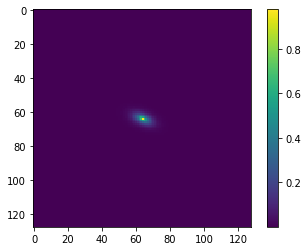

In [101]:
plt.imshow(x_opt);plt.colorbar()

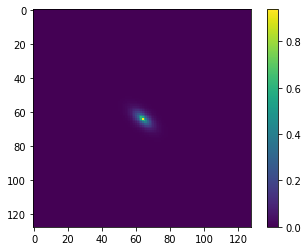

In [102]:
plt.imshow(gal_target);plt.colorbar()

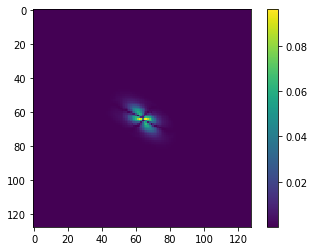

In [103]:
plt.imshow(np.abs(gal_target-x_opt));plt.colorbar()

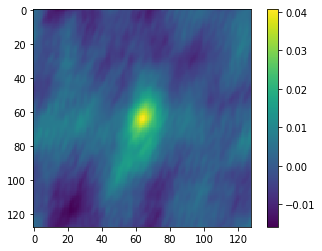

In [104]:
plt.imshow(gal_input);plt.colorbar()